In [1]:
! pip install evaluate

  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import evaluate
from nltk.corpus import stopwords
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import RobertaModel, RobertaTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from tqdm import tqdm
import re

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df1 = pd.read_csv("/kaggle/input/semeval/twitter-2016dev-A.tsv", delimiter = "\t", header = None, names = ["timestamp", "label", "text"])
df2 = pd.read_csv("/kaggle/input/semeval/twitter-2016train-A.tsv", delimiter = "\t", header = None, names = ["timestamp", "label", "text"])
df3 = pd.read_csv("/kaggle/input/semeval/twitter-2016test-A.tsv", sep='\t', header=None, names = ["timestamp", "label", "text"], usecols=[0, 1, 2])

In [4]:
df1.drop_duplicates(subset=['label', "text"], inplace = True)
df2.drop_duplicates(subset=['label', "text"], inplace = True)
df3.drop_duplicates(subset=['label', "text"], inplace = True)

In [5]:
def clean_text(text):
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'&[a-zA-Z]+;', '', text)
    
    emoticons = {
        ":)": "<smile>",
        ":(": "<sadface>",
        ":D": "<lolface>",
        ":-)": "<smile>",
        ":-(": "<sadface>",
        ":-D": "<lolface>",
        ";)": "<wink>",
        ";(": "<sadface>",
        ";D": "<lolface>",
        ";-)": "<wink>",
        ";-(": "<sadface>",
        ";-D": "<lolface>"
    }
    
    for emoticon, replacement in emoticons.items():
        text = text.replace(emoticon, replacement)
    
    text = text.lower()
    
    text = re.sub(r'\bu\b', 'you', text)
   
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
         
    return text

In [6]:
df1["text"] = df1["text"].apply(clean_text)
df2["text"] = df2["text"].apply(clean_text)
df3["text"] = df3["text"].apply(clean_text)

In [7]:
replace_dict = {
    "neutral":1,
    "positive":2,
    "negative":0
}

df1["label"] = df1["label"].replace(replace_dict)
df2["label"] = df2["label"].replace(replace_dict)
df3["label"] = df3["label"].replace(replace_dict)

In [8]:
X_train, y_train = df2['text'], df2['label']
X_dev, y_dev = df1['text'], df1['label']
X_test, y_test = df3['text'], df3['label']

In [9]:
from datasets import Dataset

train_data = Dataset.from_dict({'text': X_train, 'score': y_train})
dev_data = Dataset.from_dict({'text': X_dev, 'score': y_dev})
test_data = Dataset.from_dict({'text': X_test, 'score': y_test})

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader

BASE_MODEL = "roberta-base"
MAX_LENGTH = 256

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
ds = {"train": train_data, "validation": dev_data, "test": test_data}

def preprocess_function(examples):
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    examples["label"] = float(label)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["text", "score"])

  0%|          | 0/5849 [00:00<?, ?ex/s]

  0%|          | 0/1966 [00:00<?, ?ex/s]

  0%|          | 0/20580 [00:00<?, ?ex/s]

In [12]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    
    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()
    recall = recall_score(labels, np.around(logits, decimals=0), average = "macro")
    
    # Compute accuracy 
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in single_squared_errors if e < 0.25]) / len(single_squared_errors)
    
    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy, "recall": recall}

In [13]:
import torch

class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [14]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="../models/roberta-fine-tuned-regression-2",
    learning_rate=1e-3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [15]:
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy,Recall
1,No log,0.613283,0.613283,0.687699,-0.074210,0.379451,0.333333
2,0.680200,0.580725,0.580725,0.670969,-0.017183,0.379451,0.333333
3,0.544000,0.594223,0.594223,0.679369,-0.040825,0.379451,0.333333
4,0.544000,0.590429,0.590429,0.677337,-0.034180,0.379451,0.333333
5,0.536300,0.592147,0.592147,0.678280,-0.037190,0.379451,0.333333


TrainOutput(global_step=1830, training_loss=0.5759800311646175, metrics={'train_runtime': 1560.998, 'train_samples_per_second': 18.735, 'train_steps_per_second': 1.172, 'total_flos': 3847306863275520.0, 'train_loss': 0.5759800311646175, 'epoch': 5.0})

In [18]:
training_args = TrainingArguments(
    output_dir="../models/roberta-fine-tuned-regression-3",
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy,Recall
1,No log,0.691880,0.691880,0.692795,-0.211878,0.454730,0.363317
2,0.571800,0.570927,0.570927,0.654822,-0.000020,0.379451,0.333333
3,0.527200,0.614676,0.614676,0.688073,-0.076651,0.379959,0.334186
4,0.527200,0.584394,0.584394,0.673640,-0.023610,0.379451,0.333333
5,0.547000,0.601332,0.601332,0.682775,-0.053277,0.379451,0.333333


Checkpoint destination directory ../models/roberta-fine-tuned-regression-3/checkpoint-366 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1830, training_loss=0.5449480984380336, metrics={'train_runtime': 1059.7619, 'train_samples_per_second': 27.596, 'train_steps_per_second': 1.727, 'total_flos': 3847306863275520.0, 'train_loss': 0.5449480984380336, 'epoch': 5.0})

In [40]:
training_args = TrainingArguments(
    output_dir="../models/roberta-fine-tuned-regression-3",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy,Recall
1,No log,0.444802,0.444802,0.516608,0.220897,0.545270,0.461682
2,0.435300,0.381997,0.381997,0.485646,0.330904,0.586470,0.518103
3,0.288700,0.389354,0.389354,0.493518,0.318018,0.586470,0.528686
4,0.288700,0.413399,0.413399,0.485724,0.275902,0.597660,0.569668
5,0.231600,0.438779,0.438779,0.493684,0.231446,0.592574,0.559216


Checkpoint destination directory ../models/roberta-fine-tuned-regression-3/checkpoint-366 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1830, training_loss=0.2970592269480554, metrics={'train_runtime': 1059.8949, 'train_samples_per_second': 27.592, 'train_steps_per_second': 1.727, 'total_flos': 3847306863275520.0, 'train_loss': 0.2970592269480554, 'epoch': 5.0})

In [22]:
training_args = TrainingArguments(
    output_dir="../models/roberta-fine-tuned-regression-3",
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy,Recall
1,No log,0.479479,0.479479,0.566741,0.160158,0.515259,0.429105
2,0.761200,0.417458,0.417458,0.517676,0.268791,0.541200,0.454289
3,0.395300,0.425727,0.425727,0.510662,0.254308,0.550356,0.463615
4,0.395300,0.411418,0.411418,0.502935,0.279372,0.557986,0.478332
5,0.373100,0.428229,0.428229,0.506550,0.249925,0.556968,0.471637


TrainOutput(global_step=1830, training_loss=0.48360563601301015, metrics={'train_runtime': 1053.2912, 'train_samples_per_second': 27.765, 'train_steps_per_second': 1.737, 'total_flos': 3847306863275520.0, 'train_loss': 0.48360563601301015, 'epoch': 5.0})

In [24]:
training_args = TrainingArguments(
    output_dir="../models/roberta-fine-tuned-regression-3",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy,Recall
1,No log,0.420566,0.420566,0.501648,0.263347,0.554934,0.460513
2,No log,0.389566,0.389566,0.509384,0.317646,0.576297,0.527526
3,0.403000,0.430078,0.430078,0.516545,0.246686,0.572228,0.502528
4,0.403000,0.425601,0.425601,0.501272,0.254529,0.577314,0.531701
5,0.403000,0.438124,0.438124,0.504890,0.232593,0.581384,0.536812


TrainOutput(global_step=915, training_loss=0.33678756463723103, metrics={'train_runtime': 876.3297, 'train_samples_per_second': 33.372, 'train_steps_per_second': 1.044, 'total_flos': 3847306863275520.0, 'train_loss': 0.33678756463723103, 'epoch': 5.0})

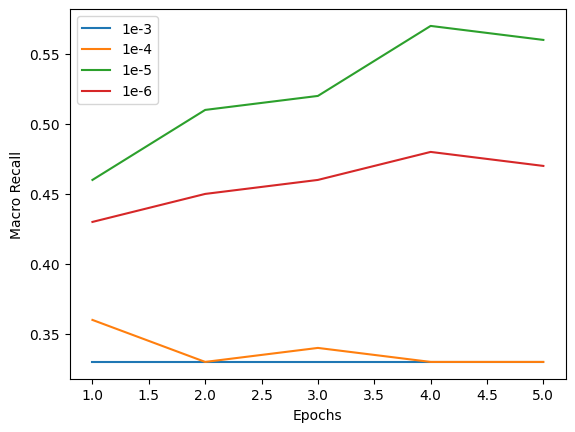

In [28]:
import matplotlib.pyplot as plt

epochs = list(range(1, 6))  

lr_3 = [0.33, 0.33, 0.33, 0.33, 0.33]
lr_4 = [0.36, 0.33, 0.34, 0.33, 0.33]
lr_5 = [0.46, 0.51, 0.52, 0.57, 0.56]
lr_6 = [0.43, 0.45, 0.46, 0.48, 0.47]

plt.plot(epochs, lr_3, label='1e-3')
plt.plot(epochs, lr_4, label='1e-4')
plt.plot(epochs, lr_5, label='1e-5')
plt.plot(epochs, lr_6, label='1e-6')

plt.xlabel('Epochs')
plt.ylabel('Macro Recall')
plt.legend()
plt.show()


In [29]:
training_args = TrainingArguments(
    output_dir="../models/roberta-fine-tuned-regression-3",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy,Recall
1,No log,0.411648,0.411648,0.539981,0.278969,0.530519,0.473964
2,No log,0.389402,0.389402,0.500968,0.317934,0.571719,0.513010
3,No log,0.393174,0.393174,0.503872,0.311326,0.570193,0.515416
4,No log,0.413753,0.413753,0.500067,0.275281,0.580875,0.544243
5,No log,0.423134,0.423134,0.500578,0.258849,0.576806,0.531842


TrainOutput(global_step=460, training_loss=0.38480612713357676, metrics={'train_runtime': 806.3054, 'train_samples_per_second': 36.27, 'train_steps_per_second': 0.571, 'total_flos': 3847306863275520.0, 'train_loss': 0.38480612713357676, 'epoch': 5.0})

In [32]:
size8 = [0.46, 0.52, 0.53, 0.57, 0.56]
size16 = [0.46, 0.53, 0.50, 0.53, 0.54]
size32 = [0.47, 0.51, 0.52, 0.54, 0.53]

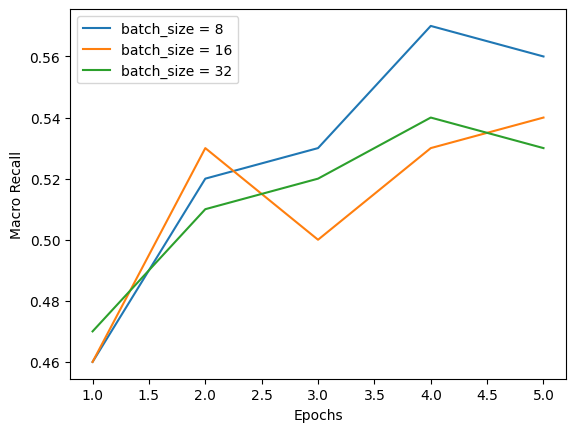

In [33]:
epochs = list(range(1, 6))  
plt.plot(epochs, size8, label='batch_size = 8')
plt.plot(epochs, size16, label='batch_size = 16')
plt.plot(epochs, size32, label='batch_size = 32')

plt.xlabel('Epochs')
plt.ylabel('Macro Recall')
plt.legend()
plt.show()

In [41]:
training_args = TrainingArguments(
    output_dir="../models/roberta-fine-tuned-regression-3",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [42]:
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy,Recall
1,No log,0.442352,0.442352,0.514632,0.225188,0.557477,0.474939
2,0.424300,0.368271,0.368271,0.489109,0.354946,0.593082,0.550573
3,0.289000,0.381826,0.381826,0.491391,0.331203,0.587996,0.537773
4,0.289000,0.399026,0.399026,0.482686,0.301077,0.596134,0.568324
5,0.225300,0.427886,0.427886,0.489543,0.250526,0.596643,0.568154


TrainOutput(global_step=1830, training_loss=0.290884860096082, metrics={'train_runtime': 1052.789, 'train_samples_per_second': 27.779, 'train_steps_per_second': 1.738, 'total_flos': 3847306863275520.0, 'train_loss': 0.290884860096082, 'epoch': 5.0})

In [43]:
trainer.eval_dataset=ds["test"]
trainer.evaluate()

{'eval_loss': 0.3871164917945862,
 'eval_mse': 0.3871164917945862,
 'eval_mae': 0.4732784330844879,
 'eval_r2': 0.16630532793050024,
 'eval_accuracy': 0.576287657920311,
 'eval_recall': 0.5853779335394229,
 'eval_runtime': 273.4949,
 'eval_samples_per_second': 75.248,
 'eval_steps_per_second': 9.408,
 'epoch': 5.0}